In [1]:
#importing the libraries
import torch
from pathlib import Path
import gzip, pickle
from torch import nn
from torch import tensor
from torch.utils.data import DataLoader
from torch import optim
import requests
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import torch.nn.utils.prune as prune
from math import ceil
from torch.autograd import Variable
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print( device)

cpu


### Loading the dataset


In [5]:
import torchvision

In [6]:
train_dataset = torchvision.datasets.MNIST('/content/drive/MyDrive/ml project/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
test_dataset =torchvision.datasets.MNIST('/content/drive/MyDrive/ml project/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               
                             ]))

In [7]:
train_dataset,val_dataset=torch.utils.data.dataset.random_split(train_dataset,lengths=[50000,10000],generator=torch.Generator().manual_seed(1))

In [8]:
BATCH_SIZE=256

In [9]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Training LeNet 5 on MNIST

In [11]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
    self.average1 = nn.AvgPool2d(2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.average2 = nn.AvgPool2d(2, stride=2)
    self.conv3 = nn.Conv2d(16, 120, kernel_size=4, stride=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(120, 82)
    self.fc2 = nn.Linear(82,10)
  def forward(self,xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = torch.tanh(self.conv1(xb))
    xb = self.average1(xb)
    xb = torch.tanh(self.conv2(xb))
    xb = self.average2(xb)
    xb = torch.tanh(self.conv3(xb))
    xb = xb.view(-1, xb.shape[1])
    xb = torch.tanh(self.fc1(xb))
    xb = F.softmax(self.fc2(xb),dim=1)
    return xb

In [12]:
model=Network()

In [13]:
model.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (average1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (average2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=10, bias=True)
)

In [14]:
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)

In [15]:
crieteria=nn.CrossEntropyLoss()

In [16]:
n_epochs=50
train_loss=[]
val_loss=[]
train_accuracy=[]
val_accuracy=[]

In [17]:
from torch.autograd import Variable

In [18]:
#training the model
model.train()
for epoch in range(n_epochs):
  tr_loss=0
  vl_loss=0
  print(f"-----------EPOCH {epoch} ------------------ ")
  correct=0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    train = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(train)
    loss = crieteria(outputs, labels)
    tr_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
    loss.backward()
    optimizer.step()
  train_loss.append(tr_loss/len(train_dataset))
  train_accuracy.append(correct/len(train_dataset))
  print(f"Training loss :{tr_loss/len(train_dataset)}")
  print(f"Training Accuracy :{correct/len(train_dataset)}")
  correct=0
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    val = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(val)
    loss = crieteria(outputs, labels)
    vl_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
  val_loss.append(vl_loss/len(val_dataset))
  val_accuracy.append(correct/len(val_dataset))
  print(f"Validation loss :{vl_loss/len(val_dataset)}")
  print(f"Validation Accuracy :{correct/len(val_dataset)}")
  

-----------EPOCH 0 ------------------ 
Training loss :2.0533199841308596
Training Accuracy :0.45302000641822815
Validation loss :1.6203571723937988
Validation Accuracy :0.8737999796867371
-----------EPOCH 1 ------------------ 
Training loss :1.5639444390869142
Training Accuracy :0.9113399982452393
Validation loss :1.532615401649475
Validation Accuracy :0.9372000098228455
-----------EPOCH 2 ------------------ 
Training loss :1.5232031604003906
Training Accuracy :0.945360004901886
Validation loss :1.5097861770629883
Validation Accuracy :0.9574999809265137
-----------EPOCH 3 ------------------ 
Training loss :1.5042078814315796
Training Accuracy :0.962660014629364
Validation loss :1.4986253480911256
Validation Accuracy :0.9667999744415283
-----------EPOCH 4 ------------------ 
Training loss :1.4946864441680907
Training Accuracy :0.9710800051689148
Validation loss :1.4945920263290404
Validation Accuracy :0.9696999788284302
-----------EPOCH 5 ------------------ 
Training loss :1.48931452110

In [ ]:
model(test_dataset[100][0].view(1,1,28,28).to(device))

tensor([[3.0256e-09, 1.0799e-12, 7.3252e-12, 7.8732e-15, 3.2393e-10, 1.5599e-08,
         1.0000e+00, 1.4372e-17, 2.1705e-10, 1.1894e-14]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
#calculating the test accuracy
tloss=0
correct=0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    val = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(val)
    loss = crieteria(outputs, labels)
    tloss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
print(f"Test loss :{tloss/len(test_dataset)}")
print(f"Test Accuracy :{correct/len(test_dataset)}")

Test loss :1.4730134588241577
Test Accuracy :0.9886999726295471


In [ ]:
torch.save(model,"/content/drive/MyDrive/ml project/model2")

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [ ]:
#total parameters in the network
pytorch_total_params

44164

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
model.train()

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (average1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (average2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=10, bias=True)
)

In [ ]:
optimizer.zero_grad()

In [ ]:
for param in model.fc1.parameters():
  print(param)

Parameter containing:
tensor([ 0.0608,  0.2011,  0.6849,  0.2564, -0.1412,  0.0668,  0.1221, -0.0583,
        -0.3159, -0.0975, -0.0457, -0.2004,  0.0364,  0.0475,  0.1490,  0.3465,
        -0.3376,  0.2400,  0.0130,  0.2343,  0.2130, -0.1638,  0.1637,  0.1158,
         0.0395, -0.0315,  0.0062,  0.0129, -0.1581,  0.2562, -0.0077, -0.1265,
         0.1163, -0.1926,  0.2658,  0.1729, -0.0411,  0.1477,  0.2990,  0.2269,
        -0.5222, -0.1150,  0.1145,  0.5554,  0.2739, -0.1449, -0.1264,  0.0378,
         0.0972, -0.3256, -0.1472,  0.3207,  0.1762,  0.1192,  0.2971,  0.5053,
        -0.2063,  0.1859,  0.3448, -0.1508,  0.0428, -0.3604, -0.0049, -0.1322,
         0.2058,  0.0912, -0.0845, -0.2479,  0.4464,  0.0568, -0.0521,  0.6571,
         0.2001, -0.1355, -0.0715,  0.3711,  0.0446,  0.0529, -0.0019, -0.1393,
         0.0122,  0.2363], requires_grad=True)
Parameter containing:
tensor([[-0.0072,  0.2502, -0.0080,  ...,  0.2293, -0.0663,  0.1237],
        [ 0.0927,  0.0272, -0.0316,  ..

In [ ]:
model.conv1.state_dict()['weight'][0].requires_grad_()

tensor([[[ 0.6536,  0.4153,  0.1016, -0.0549,  0.2247],
         [ 0.6460,  0.5103,  0.4427,  0.9069,  0.7212],
         [ 0.0761, -0.1059,  0.1549,  0.3064,  0.5972],
         [-0.0661, -0.2658, -0.4700, -0.3933,  0.0972],
         [-0.2414, -0.1098, -0.6007, -0.2149, -0.2794]]], requires_grad=True)

#### Magnitude based pruning 

In [ ]:
#pruning and measuring test accuracy 
acc_wr=[0.9886999726295471]
sparsity_wr=[1]
for i in range(20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )

  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity_wr.append((1-0.2)**(i+1))
  acc_wr.append(correct/len(test_dataset))

Test loss :1.4730134824752807
Test Accuracy :0.9886000156402588
Test loss :1.4738411441802979
Test Accuracy :0.9878000020980835
Test loss :1.4745976753234864
Test Accuracy :0.9869999885559082
Test loss :1.476237947654724
Test Accuracy :0.9854000210762024
Test loss :1.4794638544082641
Test Accuracy :0.9836000204086304
Test loss :1.4858250396728516
Test Accuracy :0.9779000282287598
Test loss :1.5146130233764648
Test Accuracy :0.9527999758720398
Test loss :1.5330720083236695
Test Accuracy :0.9415000081062317
Test loss :1.614371541595459
Test Accuracy :0.8682000041007996
Test loss :1.6852333152770995
Test Accuracy :0.8034999966621399
Test loss :1.7962515274047852
Test Accuracy :0.6876999735832214
Test loss :1.9339563858032227
Test Accuracy :0.5555999875068665
Test loss :2.046575856399536
Test Accuracy :0.48570001125335693
Test loss :2.1575523933410645
Test Accuracy :0.3517000079154968
Test loss :2.2310472789764404
Test Accuracy :0.2554999887943268
Test loss :2.279808564376831
Test Accuracy

In [ ]:
import matplotlib.pyplot as plt

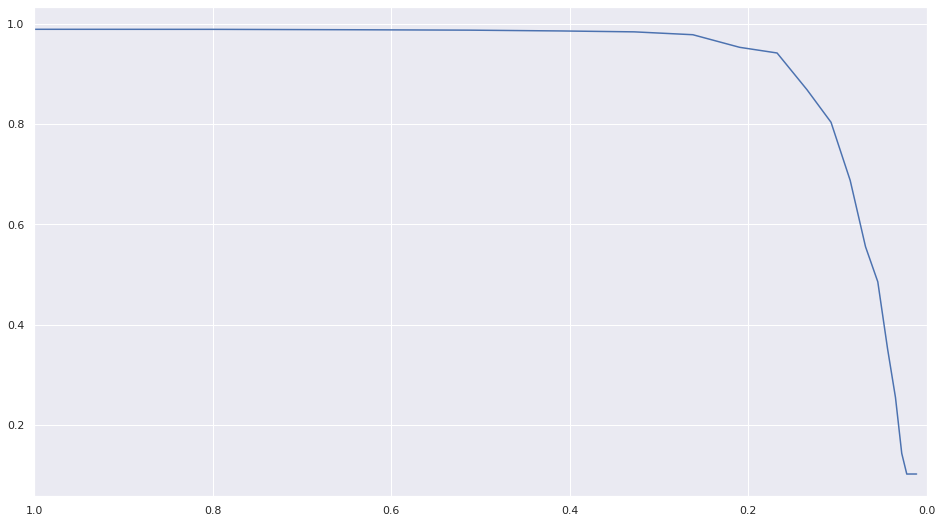

In [ ]:
#plotting sparsity vs accuracy
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.plot(sparsity,acc)

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model2")

In [ ]:
#magnitude based pruning with retraining 
acc=[0.9886999726295471]
sparsity=[1]
for i in range(20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )
  n_epochs=7
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  learning_rate = 0.01
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")


  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity.append((1-0.2)**(i+1))
  acc.append(correct/len(test_dataset))

-----------EPOCH 0 ------------------ 
Training loss :1.464194799118042
Training Accuracy :0.997219979763031
Validation loss :1.4724568607330322
Validation Accuracy :0.9891999959945679
-----------EPOCH 1 ------------------ 
Training loss :1.4641620590972901
Training Accuracy :0.9972400069236755
Validation loss :1.472394186782837
Validation Accuracy :0.9894000291824341
-----------EPOCH 2 ------------------ 
Training loss :1.4641505285263061
Training Accuracy :0.9972400069236755
Validation loss :1.4723716617584228
Validation Accuracy :0.989300012588501
-----------EPOCH 3 ------------------ 
Training loss :1.4641415559768676
Training Accuracy :0.9972400069236755
Validation loss :1.4723522190093994
Validation Accuracy :0.9894999861717224
-----------EPOCH 4 ------------------ 
Training loss :1.4641358279037475
Training Accuracy :0.9972400069236755
Validation loss :1.4723354740142822
Validation Accuracy :0.989300012588501
-----------EPOCH 5 ------------------ 
Training loss :1.46413173591613

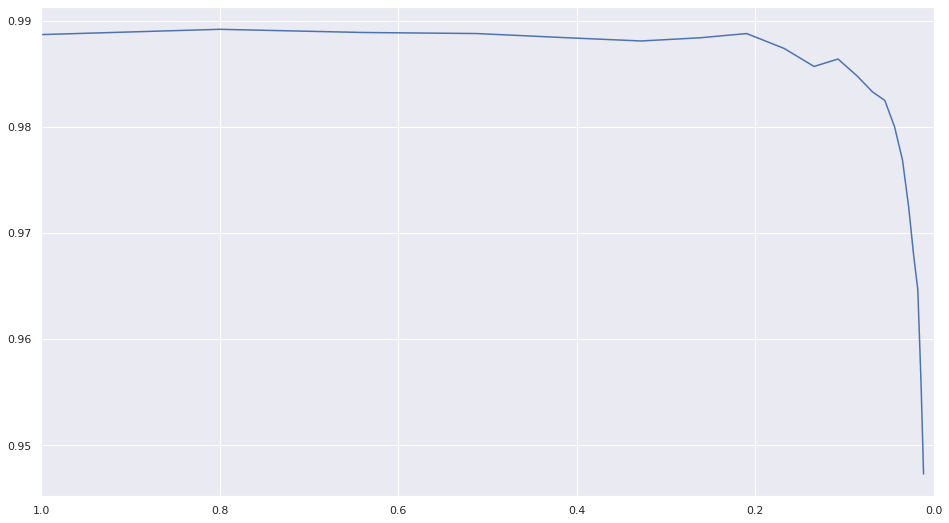

In [ ]:
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.plot(sparsity,acc)


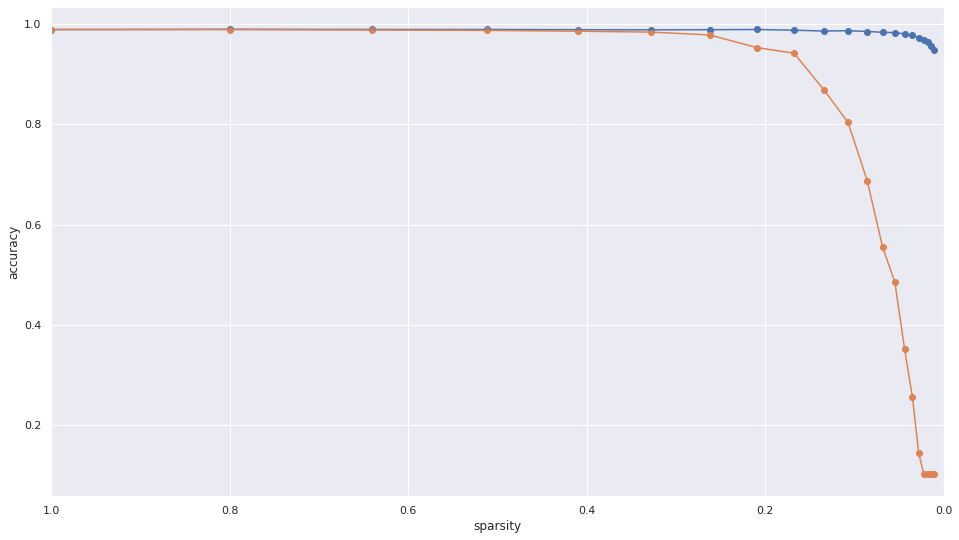

In [ ]:
#comparing pruning with and without retraining 
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.xlabel("sparsity")
plt.ylabel("accuracy")

plt.scatter(sparsity,acc)
plt.scatter(sparsity_wr,acc_wr)
plt.plot(sparsity,acc)
plt.plot(sparsity_wr,acc_wr)

In [ ]:
sparsity_wr,acc_wr

([1,
  0.8,
  0.6400000000000001,
  0.5120000000000001,
  0.4096000000000001,
  0.3276800000000001,
  0.2621440000000001,
  0.20971520000000007,
  0.1677721600000001,
  0.13421772800000006,
  0.10737418240000006,
  0.08589934592000005,
  0.06871947673600004,
  0.054975581388800036,
  0.043980465111040035,
  0.03518437208883203,
  0.028147497671065624,
  0.022517998136852502,
  0.018014398509482003,
  0.014411518807585602,
  0.011529215046068483],
 [0.9886999726295471,
  tensor(0.9886),
  tensor(0.9878),
  tensor(0.9870),
  tensor(0.9854),
  tensor(0.9836),
  tensor(0.9779),
  tensor(0.9528),
  tensor(0.9415),
  tensor(0.8682),
  tensor(0.8035),
  tensor(0.6877),
  tensor(0.5556),
  tensor(0.4857),
  tensor(0.3517),
  tensor(0.2555),
  tensor(0.1439),
  tensor(0.1027),
  tensor(0.1028),
  tensor(0.1028),
  tensor(0.1028)])

#### Apply L1 norm based structured pruning


In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model2")

In [ ]:
#applying L1 norm based structured pruning with retraining
acc=[0.9886999726295471]
sparsity=[1]
for i in range(20):
  #prune.ln_structured(model.conv1,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv2,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv3,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.fc1,'weight',amount=0.2,dim=0,n=1)
  #prune.ln_structured(model.fc2,'weight',amount=0.2,dim=0,n=1)
  #computing the number of parameters pruned
  no_removed=0
  for i in range(model.conv2.state_dict()['weight_mask'].shape[0]):
    if model.conv2.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv2.state_dict()['weight_mask'][i])
  for i in range(model.conv3.state_dict()['weight_mask'].shape[0]):
    if model.conv3.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv3.state_dict()['weight_mask'][i])
  for i in range(model.fc1.state_dict()['weight_mask'].shape[0]):
    if model.fc1.state_dict()['weight_mask'][i][0]==0:
      no_removed+=torch.numel(model.fc1.state_dict()['weight_mask'][i])
  
  print(f"Sparsity= : {1-(no_removed/44164)}")
  model.conv2.state_dict()['weight_mask']
  n_epochs=9
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  learning_rate = 0.01
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")


  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity.append(1-(no_removed/44164))
  acc.append(correct/len(test_dataset))

Sparsity= : 0.8072185490444705
-----------EPOCH 0 ------------------ 
Training loss :1.470521646194458
Training Accuracy :0.9931600093841553
Validation loss :1.4762423194885255
Validation Accuracy :0.9865000247955322
-----------EPOCH 1 ------------------ 
Training loss :1.4672634822845458
Training Accuracy :0.9958199858665466
Validation loss :1.4755644702911377
Validation Accuracy :0.9872999787330627
-----------EPOCH 2 ------------------ 
Training loss :1.46668001537323
Training Accuracy :0.9963399767875671
Validation loss :1.475302142715454
Validation Accuracy :0.9873999953269958
-----------EPOCH 3 ------------------ 
Training loss :1.4663547346115113
Training Accuracy :0.9966199994087219
Validation loss :1.475139329147339
Validation Accuracy :0.9873999953269958
-----------EPOCH 4 ------------------ 
Training loss :1.4661302740859985
Training Accuracy :0.9967799782752991
Validation loss :1.4748840015411377
Validation Accuracy :0.9873999953269958
-----------EPOCH 5 ------------------ 


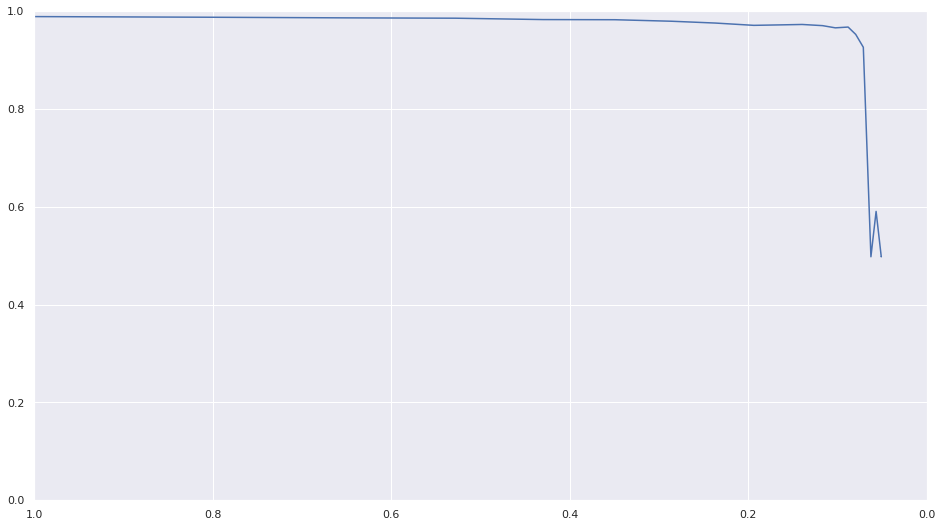

In [ ]:
#plotting accuracy vs sparsity
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,1)
plt.plot(sparsity,acc)

In [ ]:
#applying L1 norm based structured pruning without retraining
acc_wr=[0.9886999726295471]
sparsity_wr=[1]
for i in range(20):
  #prune.ln_structured(model.conv1,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv2,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv3,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.fc1,'weight',amount=0.2,dim=0,n=1)
  #prune.ln_structured(model.fc2,'weight',amount=0.2,dim=0,n=1)
  #computing number of parameters pruned
  no_removed=0
  for i in range(model.conv2.state_dict()['weight_mask'].shape[0]):
    if model.conv2.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv2.state_dict()['weight_mask'][i])
  for i in range(model.conv3.state_dict()['weight_mask'].shape[0]):
    if model.conv3.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv3.state_dict()['weight_mask'][i])
  for i in range(model.fc1.state_dict()['weight_mask'].shape[0]):
    if model.fc1.state_dict()['weight_mask'][i][0]==0:
      no_removed+=torch.numel(model.fc1.state_dict()['weight_mask'][i])
  
  print(f"Sparsity= : {1-(no_removed/44164)}")
  
  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity_wr.append(1-(no_removed/44164))
  acc_wr.append(correct/len(test_dataset))

Sparsity= : 0.8072185490444705
Test loss :1.4890833923339843
Test Accuracy :0.9742000102996826
Sparsity= : 0.651571415632642
Test loss :1.739274455833435
Test Accuracy :0.7261999845504761
Sparsity= : 0.5279413096639798
Test loss :1.8845881967544555
Test Accuracy :0.5950999855995178
Sparsity= : 0.4298523684448873
Test loss :1.9712235710144044
Test Accuracy :0.5238999724388123
Sparsity= : 0.34947015668870574
Test loss :2.0563047119140627
Test Accuracy :0.44929999113082886
Sparsity= : 0.28611538809890413
Test loss :2.115550154495239
Test Accuracy :0.37439998984336853
Sparsity= : 0.23707091748935782
Test loss :2.171288803863525
Test Accuracy :0.3294999897480011
Sparsity= : 0.19382302327687706
Test loss :2.2363115077972413
Test Accuracy :0.21170000731945038
Sparsity= : 0.16248528213024183
Test loss :2.2354837699890138
Test Accuracy :0.287200003862381
Sparsity= : 0.13966126256679645
Test loss :2.2569492305755614
Test Accuracy :0.23739999532699585
Sparsity= : 0.11683724300335119
Test loss :2.

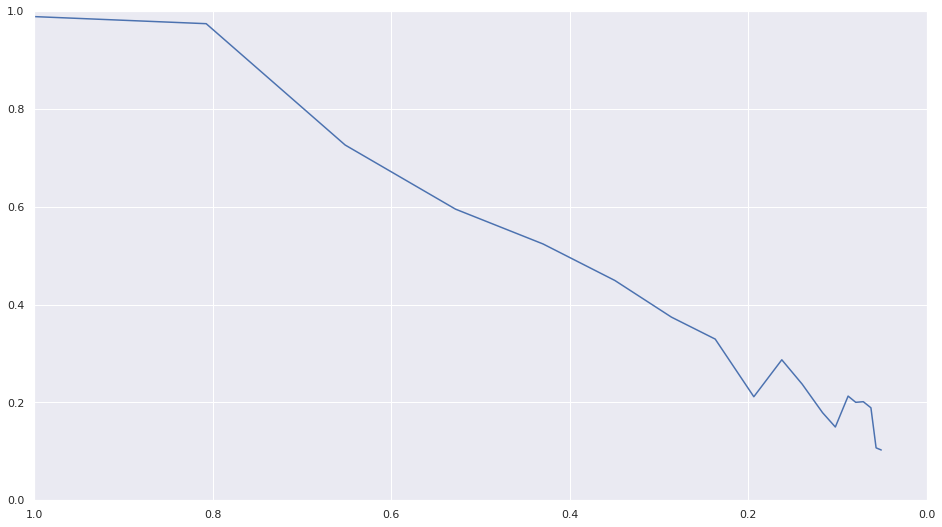

In [ ]:
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,1)
plt.plot(sparsity_wr,acc_wr)

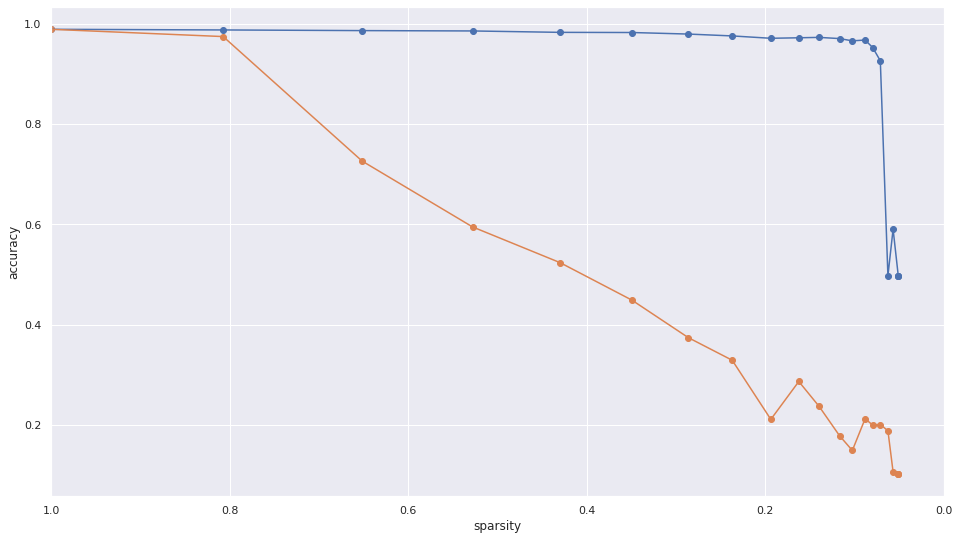

In [ ]:
#plotting the sparsity vs accuracy with and without retraining
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.xlabel("sparsity")
plt.ylabel("accuracy")

plt.scatter(sparsity,acc)
plt.scatter(sparsity_wr,acc_wr)
plt.plot(sparsity,acc)
plt.plot(sparsity_wr,acc_wr)

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model2")

##Applying lottery ticket



In [ ]:
model = Network()

In [ ]:
model.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (average1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (average2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=10, bias=True)
)

In [ ]:
model

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (average1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (average2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=10, bias=True)
)

In [ ]:
init_weights=model

In [ ]:
#saving initializations for retraining
torch.save(init_weights,"/content/drive/MyDrive/ml project/lotteryinit")

In [ ]:
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
crieteria=nn.CrossEntropyLoss()

In [ ]:
best_acc=0
early_stop=0
n_epochs=40
train_loss=[]
val_loss=[]
train_accuracy=[]
val_accuracy=[]

In [ ]:
#training and saving early stopping
model.train()
for epoch in range(n_epochs):
  tr_loss=0
  vl_loss=0
  print(f"-----------EPOCH {epoch} ------------------ ")
  correct=0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    train = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(train)
    loss = crieteria(outputs, labels)
    tr_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
    loss.backward()
    optimizer.step()
  train_loss.append(tr_loss/len(train_dataset))
  train_accuracy.append(correct/len(train_dataset))
  print(f"Training loss :{tr_loss/len(train_dataset)}")
  print(f"Training Accuracy :{correct/len(train_dataset)}")
  correct=0
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    val = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(val)
    loss = crieteria(outputs, labels)
    vl_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
  val_loss.append(vl_loss/len(val_dataset))
  val_accuracy.append(correct/len(val_dataset))
  print(f"Validation loss :{vl_loss/len(val_dataset)}")
  print(f"Validation Accuracy :{correct/len(val_dataset)}")
  if correct/len(val_dataset) > best_acc:
    best_acc=correct/len(val_dataset)
    early_stop=epoch
    torch.save(model,"/content/drive/MyDrive/ml project/lotterytrain")

-----------EPOCH 0 ------------------ 
Training loss :1.9902330178833008
Training Accuracy :0.5167999863624573
Validation loss :1.6401010416030883
Validation Accuracy :0.8306000232696533
-----------EPOCH 1 ------------------ 
Training loss :1.568544830932617
Training Accuracy :0.9047600030899048
Validation loss :1.5290344535827636
Validation Accuracy :0.9404000043869019
-----------EPOCH 2 ------------------ 
Training loss :1.517025573387146
Training Accuracy :0.9509199857711792
Validation loss :1.5074634267807008
Validation Accuracy :0.9592000246047974
-----------EPOCH 3 ------------------ 
Training loss :1.5006558365631104
Training Accuracy :0.9655200242996216
Validation loss :1.4971823369979858
Validation Accuracy :0.9678000211715698
-----------EPOCH 4 ------------------ 
Training loss :1.4921164361190795
Training Accuracy :0.9732800126075745
Validation loss :1.4916375717163086
Validation Accuracy :0.9726999998092651
-----------EPOCH 5 ------------------ 
Training loss :1.48783631927

In [ ]:
early_stop

36

In [ ]:
#reloading the initial weights
init_weights=torch.load("/content/drive/MyDrive/ml project/lotteryinit")

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/lotterytrain")

In [ ]:
from torch.nn.utils import prune

In [ ]:
#applying the magnitude based pruning with lottery ticket based initializations
sparsity=[1]
best_acc_list=[0.9884999990463257]
early_stop_list=[36]
for i in range(15):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )
  #loading from init weights
  sd=model.conv1.state_dict()
  sd["bias"]=init_weights.conv1.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv1.state_dict()['weight']
  model.conv1.load_state_dict(sd)

  sd=model.conv2.state_dict()
  sd["bias"]=init_weights.conv2.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv2.state_dict()['weight']
  model.conv2.load_state_dict(sd)

  sd=model.conv3.state_dict()
  sd["bias"]=init_weights.conv3.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv3.state_dict()['weight']
  model.conv3.load_state_dict(sd)

  sd=model.fc1.state_dict()
  sd["bias"]=init_weights.fc1.state_dict()['bias']
  sd["weight_orig"]=init_weights.fc1.state_dict()['weight']
  model.fc1.load_state_dict(sd)

  sd=model.fc2.state_dict()
  sd["bias"]=init_weights.fc2.state_dict()['bias']
  sd["weight_orig"]=init_weights.fc2.state_dict()['weight']
  model.fc2.load_state_dict(sd)


  print(f"Sparsity={(1-0.2)**(i+1)}")
  
  learning_rate = 0.1
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  crieteria=nn.CrossEntropyLoss()
  best_acc=0
  early_stop=0
  n_epochs=40
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")
    if correct/len(val_dataset) > best_acc:
      best_acc=correct/len(val_dataset)
      early_stop=epoch
  best_acc_list.append(best_acc)
  early_stop_list.append(early_stop)
  sparsity.append((1-0.2)**(i+1))

Sparsity=0.8
-----------EPOCH 0 ------------------ 
Training loss :1.921595513496399
Training Accuracy :0.607420027256012
Validation loss :1.6174136856079102
Validation Accuracy :0.8500000238418579
-----------EPOCH 1 ------------------ 
Training loss :1.544590913848877
Training Accuracy :0.9291999936103821
Validation loss :1.5165856956481933
Validation Accuracy :0.9520000219345093
-----------EPOCH 2 ------------------ 
Training loss :1.5060195120620727
Training Accuracy :0.9613800048828125
Validation loss :1.4998435695648193
Validation Accuracy :0.9666000008583069
-----------EPOCH 3 ------------------ 
Training loss :1.492469394721985
Training Accuracy :0.9733800292015076
Validation loss :1.490928783416748
Validation Accuracy :0.973800003528595
-----------EPOCH 4 ------------------ 
Training loss :1.4862624462509155
Training Accuracy :0.9789400100708008
Validation loss :1.4858691068649292
Validation Accuracy :0.9775999784469604
-----------EPOCH 5 ------------------ 
Training loss :1.48

In [ ]:
#applying the previous for 5 more steps
for i in range(15,20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )
  sd=model.conv1.state_dict()
  sd["bias"]=init_weights.conv1.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv1.state_dict()['weight']
  model.conv1.load_state_dict(sd)

  sd=model.conv2.state_dict()
  sd["bias"]=init_weights.conv2.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv2.state_dict()['weight']
  model.conv2.load_state_dict(sd)

  sd=model.conv3.state_dict()
  sd["bias"]=init_weights.conv3.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv3.state_dict()['weight']
  model.conv3.load_state_dict(sd)

  sd=model.fc1.state_dict()
  sd["bias"]=init_weights.fc1.state_dict()['bias']
  sd["weight_orig"]=init_weights.fc1.state_dict()['weight']
  model.fc1.load_state_dict(sd)

  sd=model.fc2.state_dict()
  sd["bias"]=init_weights.fc2.state_dict()['bias']
  sd["weight_orig"]=init_weights.fc2.state_dict()['weight']
  model.fc2.load_state_dict(sd)


  print(f"Sparsity={(1-0.2)**(i+1)}")
  
  learning_rate = 0.1
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  crieteria=nn.CrossEntropyLoss()
  best_acc=0
  early_stop=0
  n_epochs=40
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")
    if correct/len(val_dataset) > best_acc:
      best_acc=correct/len(val_dataset)
      early_stop=epoch
  best_acc_list.append(best_acc)
  early_stop_list.append(early_stop)
  sparsity.append((1-0.2)**(i+1))

Sparsity=0.028147497671065624
-----------EPOCH 0 ------------------ 
Training loss :2.3020632931518556
Training Accuracy :0.1085600033402443
Validation loss :2.301780164718628
Validation Accuracy :0.11509999632835388
-----------EPOCH 1 ------------------ 
Training loss :2.3015619790649415
Training Accuracy :0.11181999742984772
Validation loss :2.301277183532715
Validation Accuracy :0.11509999632835388
-----------EPOCH 2 ------------------ 
Training loss :2.301163751296997
Training Accuracy :0.11181999742984772
Validation loss :2.3007783672332764
Validation Accuracy :0.11509999632835388
-----------EPOCH 3 ------------------ 
Training loss :2.3000413639831545
Training Accuracy :0.11181999742984772
Validation loss :2.2965227680206297
Validation Accuracy :0.11509999632835388
-----------EPOCH 4 ------------------ 
Training loss :2.2096682838439943
Training Accuracy :0.22737999260425568
Validation loss :2.0708713886260988
Validation Accuracy :0.3901999890804291
-----------EPOCH 5 -----------

In [ ]:
sparsity,best_acc_list,early_stop_list

([1,
  0.8,
  0.6400000000000001,
  0.5120000000000001,
  0.4096000000000001,
  0.3276800000000001,
  0.2621440000000001,
  0.20971520000000007,
  0.1677721600000001,
  0.13421772800000006,
  0.10737418240000006,
  0.08589934592000005,
  0.06871947673600004,
  0.054975581388800036,
  0.043980465111040035,
  0.03518437208883203,
  0.028147497671065624,
  0.022517998136852502,
  0.018014398509482003,
  0.014411518807585602,
  0.011529215046068483],
 [0.9884999990463257,
  tensor(0.9886),
  tensor(0.9889),
  tensor(0.9898),
  tensor(0.9897),
  tensor(0.9893),
  tensor(0.9889),
  tensor(0.9890),
  tensor(0.9888),
  tensor(0.9883),
  tensor(0.9887),
  tensor(0.9880),
  tensor(0.9876),
  tensor(0.9855),
  tensor(0.9849),
  tensor(0.9835),
  tensor(0.9824),
  tensor(0.9771),
  tensor(0.9749),
  tensor(0.9681),
  tensor(0.9635)],
 [36,
  26,
  20,
  39,
  31,
  35,
  36,
  38,
  29,
  26,
  27,
  33,
  38,
  30,
  38,
  33,
  37,
  37,
  37,
  37,
  39])

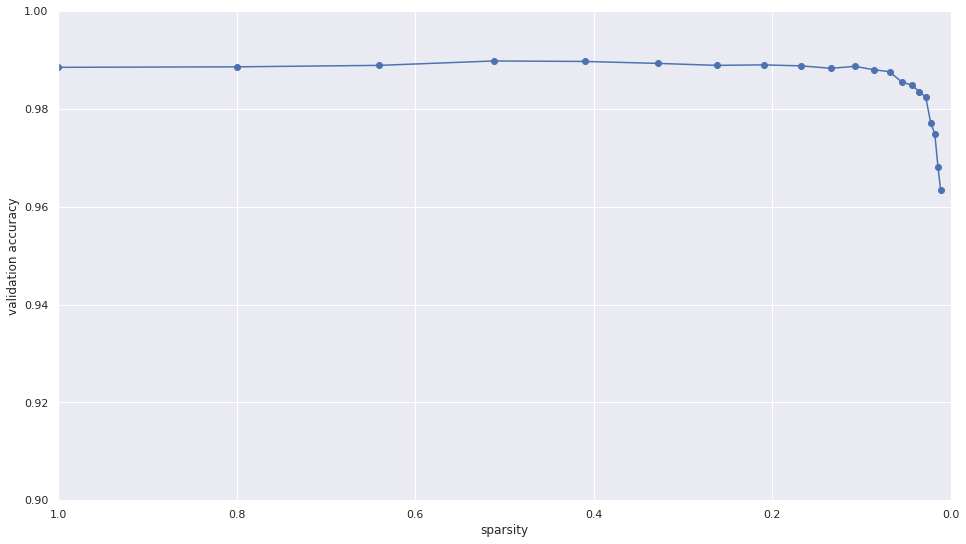

In [ ]:
#plotting sparsity vs accuracy
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0.9,1)
plt.xlabel("sparsity")
plt.ylabel("validation accuracy")
plt.scatter(sparsity,best_acc_list)
plt.plot(sparsity,best_acc_list)

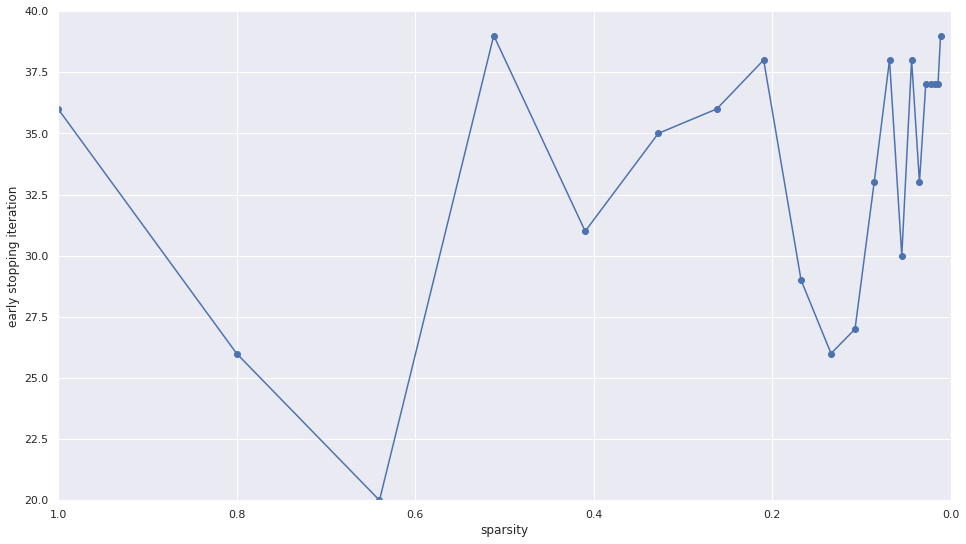

In [ ]:
#plotting early stopping 
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(20,40)
plt.xlabel("sparsity")
plt.ylabel("early stopping iteration")
plt.scatter(sparsity,early_stop_list)
plt.plot(sparsity,early_stop_list)

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/lotterytrain")

In [ ]:
#applying magnitude based pruning with random re initialization
sparsity_wr=[1]
best_acc_list_wr=[0.9884999990463257]
early_stop_list_wr=[36]
for i in range(20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )
  #reinitializing by default initialization method
  model2=Network()
  sd=model.conv1.state_dict()
  sd["bias"]=model2.conv1.state_dict()['bias']
  sd["weight_orig"]=model2.conv1.state_dict()['weight']
  model.conv1.load_state_dict(sd)

  sd=model.conv2.state_dict()
  sd["bias"]=model2.conv2.state_dict()['bias']
  sd["weight_orig"]=model2.conv2.state_dict()['weight']
  model.conv2.load_state_dict(sd)

  sd=model.conv3.state_dict()
  sd["bias"]=model2.conv3.state_dict()['bias']
  sd["weight_orig"]=model2.conv3.state_dict()['weight']
  model.conv3.load_state_dict(sd)

  sd=model.fc1.state_dict()
  sd["bias"]=model2.fc1.state_dict()['bias']
  sd["weight_orig"]=model2.fc1.state_dict()['weight']
  model.fc1.load_state_dict(sd)

  sd=model.fc2.state_dict()
  sd["bias"]=model2.fc2.state_dict()['bias']
  sd["weight_orig"]=model2.fc2.state_dict()['weight']
  model.fc2.load_state_dict(sd)



  print(f"Sparsity={(1-0.2)**(i+1)}")
  
  learning_rate = 0.1
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  crieteria=nn.CrossEntropyLoss()
  best_acc=0
  early_stop=0
  n_epochs=40
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")
    if correct/len(val_dataset) > best_acc:
      best_acc=correct/len(val_dataset)
      early_stop=epoch
  best_acc_list_wr.append(best_acc)
  early_stop_list_wr.append(early_stop)
  sparsity_wr.append((1-0.2)**(i+1))

Sparsity=0.8
-----------EPOCH 0 ------------------ 
Training loss :2.0580575341415406
Training Accuracy :0.47284001111984253
Validation loss :1.6668523887634277
Validation Accuracy :0.8119000196456909
-----------EPOCH 1 ------------------ 
Training loss :1.5817453899383545
Training Accuracy :0.8938400149345398
Validation loss :1.5432578004837036
Validation Accuracy :0.9269000291824341
-----------EPOCH 2 ------------------ 
Training loss :1.5299529343795777
Training Accuracy :0.939520001411438
Validation loss :1.5174620391845703
Validation Accuracy :0.949400007724762
-----------EPOCH 3 ------------------ 
Training loss :1.5093984843063355
Training Accuracy :0.9576200246810913
Validation loss :1.5025623680114746
Validation Accuracy :0.9628999829292297
-----------EPOCH 4 ------------------ 
Training loss :1.498169598007202
Training Accuracy :0.9676200151443481
Validation loss :1.4952838668823243
Validation Accuracy :0.9695000052452087
-----------EPOCH 5 ------------------ 
Training loss :

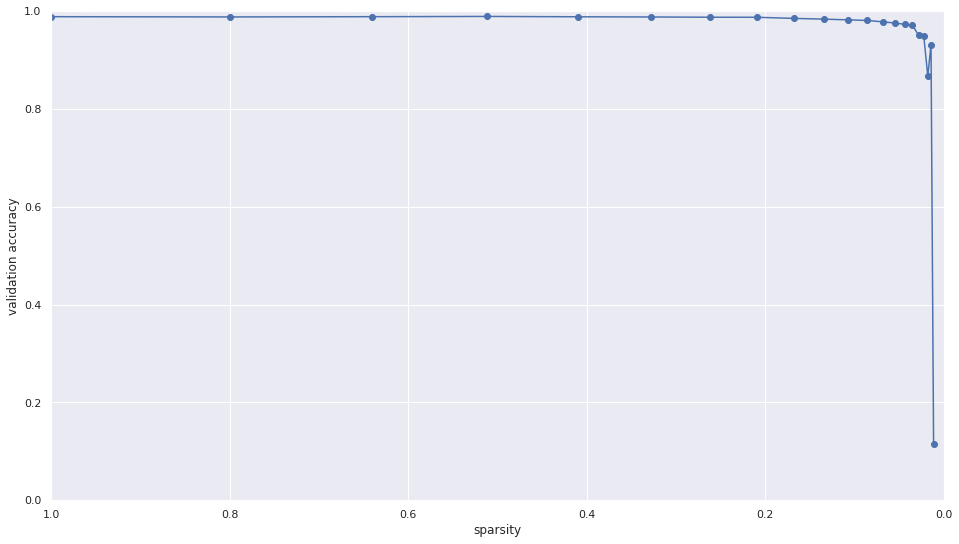

In [ ]:
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,1)
plt.xlabel("sparsity")
plt.ylabel("validation accuracy")
plt.scatter(sparsity_wr,best_acc_list_wr)
plt.plot(sparsity_wr,best_acc_list_wr)

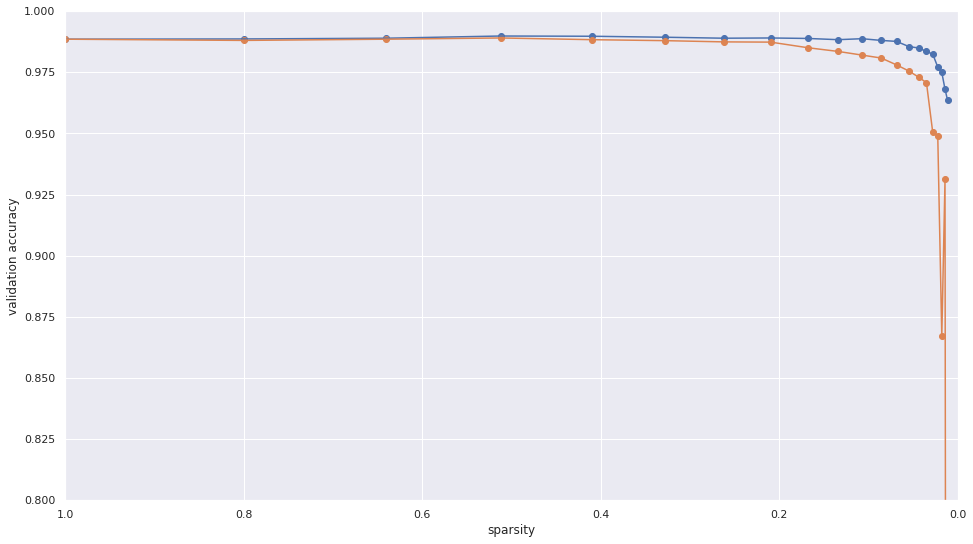

In [ ]:
#comparing acc of random reinit vs lottery ticket based init
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0.8,1)
plt.xlabel("sparsity")
plt.ylabel("validation accuracy")
plt.scatter(sparsity,best_acc_list)
plt.plot(sparsity,best_acc_list)
plt.scatter(sparsity_wr,best_acc_list_wr)
plt.plot(sparsity_wr,best_acc_list_wr)

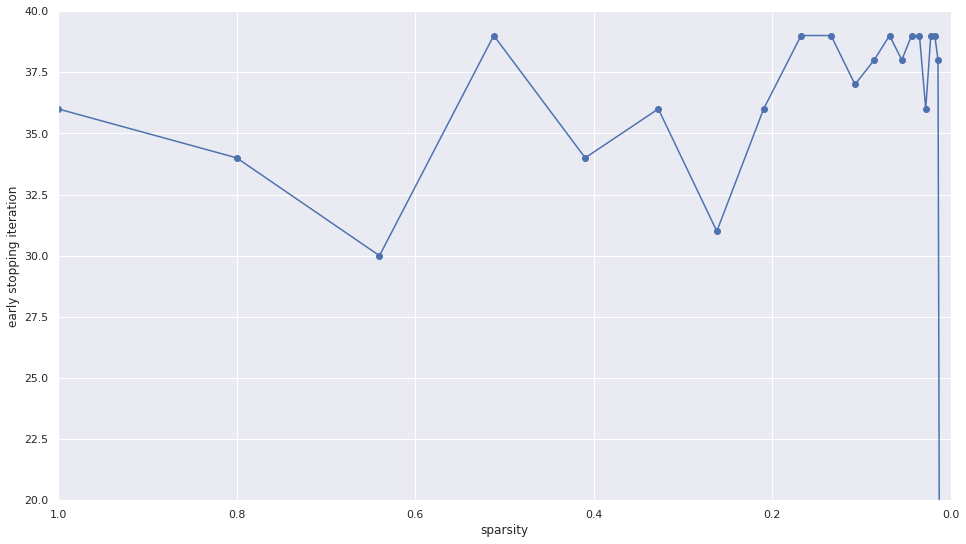

In [ ]:
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(20,40)
plt.xlabel("sparsity")
plt.ylabel("early stopping iteration")
plt.scatter(sparsity_wr,early_stop_list_wr)
plt.plot(sparsity_wr,early_stop_list_wr)

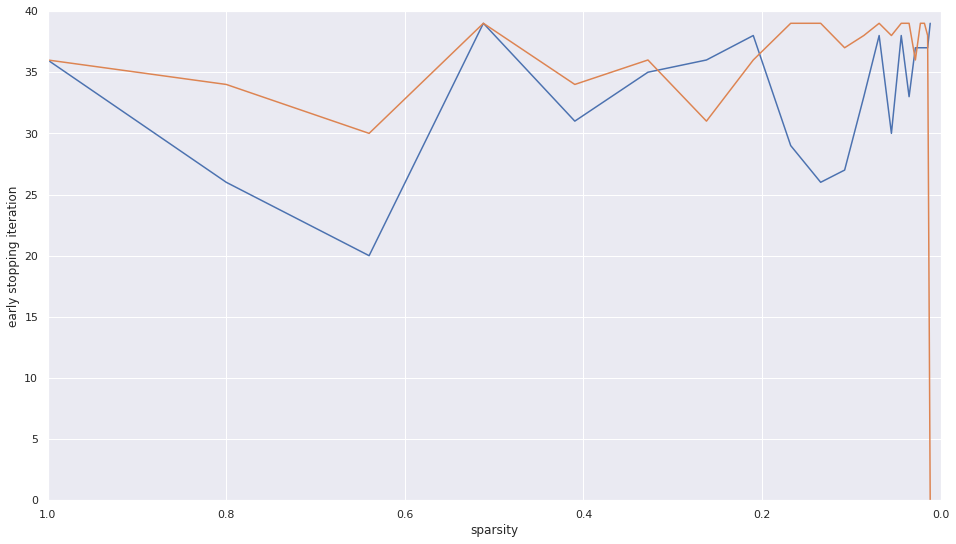

In [ ]:
#comparing early stopping iterations
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,40)
plt.xlabel("sparsity")
plt.ylabel("early stopping iteration")
#plt.scatter(sparsity,early_stop_list)
plt.plot(sparsity,early_stop_list)
#plt.scatter(sparsity_wr,early_stop_list_wr)
plt.plot(sparsity_wr,early_stop_list_wr)

In [ ]:
sparsity_wr,best_acc_list_wr,early_stop_list_wr

([1,
  0.8,
  0.6400000000000001,
  0.5120000000000001,
  0.4096000000000001,
  0.3276800000000001,
  0.2621440000000001,
  0.20971520000000007,
  0.1677721600000001,
  0.13421772800000006,
  0.10737418240000006,
  0.08589934592000005,
  0.06871947673600004,
  0.054975581388800036,
  0.043980465111040035,
  0.03518437208883203,
  0.028147497671065624,
  0.022517998136852502,
  0.018014398509482003,
  0.014411518807585602,
  0.011529215046068483],
 [0.9884999990463257,
  tensor(0.9880),
  tensor(0.9885),
  tensor(0.9890),
  tensor(0.9883),
  tensor(0.9879),
  tensor(0.9874),
  tensor(0.9873),
  tensor(0.9850),
  tensor(0.9835),
  tensor(0.9820),
  tensor(0.9808),
  tensor(0.9780),
  tensor(0.9755),
  tensor(0.9730),
  tensor(0.9707),
  tensor(0.9504),
  tensor(0.9489),
  tensor(0.8671),
  tensor(0.9312),
  tensor(0.1151)],
 [36,
  34,
  30,
  39,
  34,
  36,
  31,
  36,
  39,
  39,
  37,
  38,
  39,
  38,
  39,
  39,
  36,
  39,
  39,
  38,
  0])